In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from IPython.display import display
from scipy.stats import entropy
from datasets import load_dataset, Dataset, load_metric
import os.path
import requests
from bs4 import BeautifulSoup

In [2]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=20,
    evaluation_strategy="epoch"
    )
metric = load_metric("accuracy")

In [5]:
def compute_metrics_accuracy(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        print("Predictions", predictions, "Labels", labels)
        return metric.compute(predictions=predictions, references=labels)
        
tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")
trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
                args=training_args,
                train_dataset=None,
                eval_dataset=None,
                tokenizer=tokenizer,
                data_collator=None,
                compute_metrics = compute_metrics_accuracy)

In [ ]:

# trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
#                 args=training_args,
#                 train_dataset=None,
#                 eval_dataset=tokenized_dataset_test,
#                 tokenizer=tokenizer,
#                 data_collator=data_collator,
#                 compute_metrics = compute_metrics_accuracy)

In [23]:
pd.set_option('display.max_rows', None)
def calculate_entropy(logits):
    probas = torch.nn.Softmax(dim=1)(torch.from_numpy(logits))
    samples_entropy = entropy(probas.transpose(0, 1).cpu())
    samples_entropy = torch.from_numpy(samples_entropy)
    return samples_entropy

def preprocess_function(examples):
    return tokenizer(examples["texts"], padding = True, truncation=True)

def get_new_sample_active_learning(number_of_comments):

    ### We read in the csv that stores all of our already annotated data
    df = pd.read_csv("annotated_data/annotated_data_with_users.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment",
                     "topic_comment", "Topic_article", "Comment", "Method"])

    already_present_data = 0
    with open("annotated_data/annotated_data_training.txt", encoding="utf-8", mode="r+") as y:
        for line in y.readlines():
            if line != "\n":
                already_present_data += 1

    ### Check if we already have active learned comments that we annotated
    if os.path.isfile('annotated_data/active_learning_comments.csv'):
        progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment", "Method"], encoding="utf-8-sig", header=None)


    ### Stores comments as string that we already have in active learning csv
    bereits_comments = []
    for comment in progress_csv.Comment:
        bereits_comments.append(comment)

    ### Int which shows how many comments (manual random sampled + active learn sampled) we already have annotated
    progress = already_present_data + len(bereits_comments)


    ### Load in all scraped comments from web in csv, sliced on [progress: progress + number_of_comments]
    alle_kommentare = pd.read_csv("shuffled_corona_relevante_kommentare.txt", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], 
                                    delimiter="\t", index_col=False, skiprows=progress, nrows=number_of_comments )
    


    ### Drop all rows that are already present in the active learned csv to we don't annotate twice
    alle_kommentare = alle_kommentare.loc[~alle_kommentare["Opinion"].isin(bereits_comments)]
    display(alle_kommentare)
    alle_kommentare.reset_index(inplace=True, drop=True)
    ### Tokenize texts and get entropy, take topk 
    texte = {"texts" : [x for x in alle_kommentare["Opinion"]]}
    texte_ds= Dataset.from_dict(texte)
    tokenized_text = texte_ds.map(preprocess_function, batched=True)
    entropies = calculate_entropy(trainer.predict(tokenized_text).predictions)
    indexes = torch.topk(entropies, int(35)).indices
    
    # if os.path.isfile('annotated_data/active_learning_comments.csv'):
    #     progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], encoding="utf-8-sig", header=None)
    #     print(type(progress_csv))
    #     display(progress_csv)
    #     for row, index in progress_csv.iterrows():
    #         print(row, index)
    newdf = pd.DataFrame(columns=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
    for nummer, x in enumerate(indexes):
        satz = texte["texts"][x]
        opinion = input(f"Opinion --- {satz}")
        while opinion not in ["neutral", "positive", "negative", "exit"]:
            opinion = input(f"Opinion --- {satz}")    
        sentiment = input(f"Sentiment --- {satz}")
        while sentiment not in ["neutral", "positive", "negative"]:
            sentiment = input(f"Sentiment --- {satz}")

        
        request = requests.get("https://www.spiegel.de/wissenschaft/medizin/corona-news-am-samstag-die-wichtigsten-entwicklungen-zu-sars-cov-2-und-covid-19-a-" +alle_kommentare.loc[int(x), "ID"])
        soup = BeautifulSoup(request.content, "html.parser")
        title = soup.find("title").text
        subtitle = soup.find("meta", property="og:description")["content"]

        topic_article = input("Topic Article ------" +title + "\n" + subtitle + " " + alle_kommentare.loc[int(x), "ID"])  
        topic_comment = input("Topic comment")


        row = [alle_kommentare.loc[alle_kommentare.Opinion == satz]]
        newdf = newdf.append(row)
        newdf.reset_index(inplace=True, drop=True)
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Topic_article")] = topic_article
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("topic_comment")] = topic_comment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Sentiment")] = sentiment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Comment")] = satz
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Opinion")] = opinion

        print(opinion, sentiment,topic_article, topic_comment)
        

    newdf = newdf.drop(columns=list(newdf.columns[-2:]))
    display(newdf)
    newdf.to_csv("annotated_data/active_learning_comments.csv", mode="a", encoding="utf-8-sig", index=False, header=False)
            # df.append(line.split("\t")[0] + "\t" + line.split("\t")[1] + "\t" + line.split("\t")[2] + "\t" + line.split("\t")[3] + "\t" + line.split("\t")[4] + "\t" + opinion + "\t"
            #                       + sentiment + "\t" + klasse1 + "\t" +  klasse2 + "\t" + kommentar + "\n")
        



In [24]:
### Takes n/10 comments with highest entropy from n pool of comments

get_new_sample_active_learning(1000)

,ID,Date,Time,Comment Level,Username,Opinion,Sentiment,topic_comment,Topic_article,Comment
2,94dc8fda-057f-44a1-a0a6-bd2ef8ee422c,2021-03-24,07:26,0,HerrmannSchmidt,Diese Politik setze ich gleich mit der absolut...,NaN,NaN,NaN,NaN
4,006f2652-d8e2-41c2-8f91-0ede996402a3,2021-07-14,06:48,0,Coraggioso-Ir6WKaaMR,Mindestens Tausend von Zwanzigtausend Besucher...,NaN,NaN,NaN,NaN
5,f63a8b6e-328b-4a41-ae2f-1016bc7c5298,2020-11-01,09:42,0,Martin-CpN8rOEZg,Sehr sinnvoll wenn die BW bei Katastrophen hil...,NaN,NaN,NaN,NaN
6,0c5439f5-d106-4233-a4a4-a3c58d54cb50,2021-06-03,08:44,0,Lanius_Excubitor,Die Inzidenz ist nur noch leicht gesunken. Vie...,NaN,NaN,NaN,NaN
8,8d383948-5bbd-4c8d-bda5-0bc0a0f9d980,2021-02-05,07:18,0,HolgerHamburgo,"Heute ist der 403. Tag der Pandemie, die epide...",NaN,NaN,NaN,NaN
9,d91f1969-27f3-450c-a13d-9cb7ef9ddab1,2020-03-12,11:50,0,Alex-2o7qgnPWg,"Hallo Spiegel, wer sind denn die anderen 12 Ka...",NaN,NaN,NaN,NaN
12,1c316023-93a4-4f2c-94be-32a46d95f7a9,2021-03-23,14:13,0,Pundesbraesident,Der liebe Herr Lindner sollte seine fpbt-Maske...,NaN,NaN,NaN,NaN
14,3e74503f-5a7e-40b6-b2ad-b6b6ea580e67,2020-06-13,09:14,0,DanielNolteheinrich,"Matthias Horx ist der einzige ""Forscher"" ohne ...",NaN,NaN,NaN,NaN
17,7410fa96-ac69-4320-8c87-73351e1a382a,2020-04-03,13:25,0,Heisefan,Nicht nur Tansania. Weltweit dürften 100te Mil...,NaN,NaN,NaN,NaN
18,4c02747a-071b-41cd-918e-66ca9dc90df2,2020-11-02,15:00,0,Feldmann,So ist es. Man infiziert sich ja auch nicht nu...,NaN,NaN,NaN,NaN


100%|██████████| 1/1 [00:00<00:00,  1.99ba/s]
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: texts.
***** Running Prediction *****
  Num examples = 965
  Batch size = 1
2923it [2:02:33, 15.66it/s]

positive neutral überblick impfung
neutral neutral demos demos
neutral neutral XXX XXX
neutral negative wirtschaft wirtschaft
neutral neutral XXX XXX
positive neutral überblick politik
neutral neutral wirtschaft wirtschaft
negative positive überblick wirtschaft
negative neutral überblick politik
neutral neutral wirtschaft wirtschaft
negative neutral politik politik
negative negative überblick politik
neutral neutral impfung politik
negative negative impfung impfung
neutral neutral überblick tests
neutral neutral XXX XXX
positive neutral maßnahmen maßnahmen
neutral neutral überblick impfung
positive negative überblick maßnahmen
neutral neutral wirtschaft intesivstationen
negative negative fußball fußball
neutral neutral XXX XXX
neutral neutral maskenpflicht maskenpflicht
neutral neutral XXX XXX
positive positive  reise
negative negative infektion lockerung
negative neutral überblick tests
positive neutral maßnahmen maßnahmen
negative neutral demos maßnahmen
negative negative überblick i

,ID,Date,Time,Comment Level,Username,Opinion,Sentiment,Topic_comment,Topic_article,Comment
0,e33d4f48-aaab-4875-b69f-9fe6cfac0768,2021-06-16,08:02,0,Bey,positive,neutral,impfung,überblick,"Es ist sicherlich richtig, dass wir im Herbst ..."
1,5666987c-20d2-4a57-94d3-558923d54d6d,2020-08-03,05:59,0,Matthias_Berger,neutral,neutral,demos,demos,Bezüglich der Verletzten Polizisten Ruder der ...
2,9a06fd39-6d10-49f0-b3bd-1da87357f358,2020-07-28,16:46,0,Maxi,neutral,neutral,XXX,XXX,"Liebe Nutzer*innen, vielen Dank für das Inter..."
3,8569298b-625c-414c-a241-7f7235ae994a,2020-04-25,08:50,0,Sonja-YEUo6cPZR,neutral,negative,wirtschaft,wirtschaft,"Was würde Herr Hofreiter verteilen, wenn das s..."
4,1ef4e567-8cca-46ff-a444-01b5b671ed47,2020-10-14,11:28,0,Maxi,neutral,neutral,XXX,XXX,"Liebe Nutzer*innen, vielen Dank für Ihr Intere..."
5,95d09775-2cc7-4f8f-a8a8-ce74cd031baa,2020-03-27,17:52,0,Naturfreund,positive,neutral,politik,überblick,Das ist Europa. Es ist eine Selbstverständlich...
6,5d501054-9476-4a4e-957f-8a5f9a4a600e,2020-08-01,20:27,0,Fred-W6vgYtPZR,neutral,neutral,wirtschaft,wirtschaft,"Ich kenne eine Stadt, die hat genug Parkhäuser..."
7,bdea53ce-bf8f-46a9-bec3-37dc98e0ab7e,2020-08-23,13:25,0,Christian-3mYBzaGGg,negative,positive,wirtschaft,überblick,Dann 30 Grad im Schatten... „Stop and go“ ... ...
8,aad44705-84d1-4e34-942e-3818167de55b,2020-10-28,11:36,0,Erik-R5b3k4PZg,negative,neutral,politik,überblick,Sind das die neuen SPD Themen um Wähler zurüc...
9,dd1c2c50-43ee-4304-953f-d500aef5ab9f,2021-04-24,13:25,0,40acres_and_a_mule,neutral,neutral,wirtschaft,wirtschaft,"Kein Problem, die finden bestimmt alle bei Ama..."


In [15]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
active_learning_df["Method"] = "manual_al"
active_learning_df.to_csv("annotated_data/active_learning_comments.csv",encoding="utf-8-sig", index=False, header=False)

In [26]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
current_kommentare_df = pd.read_csv("annotated_data/annotated_data_with_users_für_al.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
full_df = current_kommentare_df.append(active_learning_df)
full_df  = full_df.sample(frac=1).reset_index(drop=True)
full_df.to_csv("annotated_data/annotated_data_with_users_and_al.csv", encoding="utf-8-sig", index=False, header=False)

<AxesSubplot:>

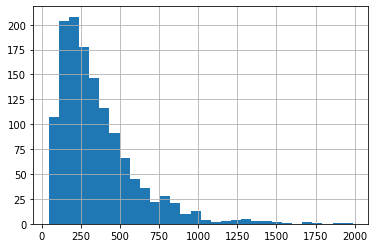

In [30]:
lengths = [len(i) for i in full_df["Comment"]]
pd.Series(lengths).hist(bins = 30)